In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import copy

## Loading and testing pre-trained model

### Loading model from [PyTorch Hub](https://pytorch.org/hub/)

In [2]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/igor/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


### Testing model inference on `CDStent_noise4.tif`

As it can be seen below, the output image is not satisfactory. The stents can be distinguished very slightly in the output by knowing their general position beforehand.

In [12]:
filename = "data/tif/CDStent_noise4.tif"
input_image = Image.open(filename)
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
input_tensor = transforms.ToTensor()(input_image)
input_tensor = input_tensor.float()
input_tensor = transforms.Normalize(mean=m, std=s)(input_tensor)
print('input_tensor size: ', input_tensor.size()) 

# Replicates image on other channels to have 3 channels
input_tensor = torch.cat([input_tensor, input_tensor, input_tensor], dim=0)
print('input_tensor size after channel replication: ', input_tensor.size()) 

input_batch = input_tensor.unsqueeze(0)
print('input_batch size: ', input_batch.size()) 

memory_available = False
if torch.cuda.is_available() and memory_available:
    torch.cuda.empty_cache() 
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output_tensor = model(input_batch)

print('output_tensor size: ', output_tensor.size())

input_tensor size:  torch.Size([1, 1024, 1024])
input_tensor size after channel replication:  torch.Size([3, 1024, 1024])
input_batch size:  torch.Size([1, 3, 1024, 1024])
output_tensor size:  torch.Size([1, 1, 1024, 1024])


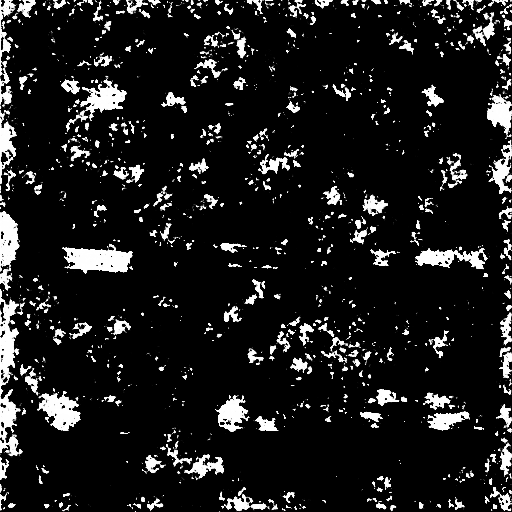

In [13]:
output_image = transforms.ToPILImage()(output_tensor[0, :])
display(output_image.resize((512, 512), Image.NEAREST)) 

## Analyzing the model

In this step, the activation output of some layers will be retrieved.

In [14]:
# Prints the original model
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [25]:
# Creates a forward hook to display feature maps
def display_feature_map(self, input, output):
    print('display_activation_image')
    print('Inside ' + self.__class__.__name__ + ' forward')
    print()
    print('input: ', type(input))
    print('output: ', type(output))
    print()
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    feature_map = output.mean(dim=1)
    feature_map = transforms.ToPILImage()(feature_map[0, :])
    display(feature_map.resize((512, 512), Image.NEAREST))

display_activation_image
Inside Sequential forward

input:  <class 'tuple'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 64, 1024, 1024])
output size: torch.Size([1, 32, 1024, 1024])


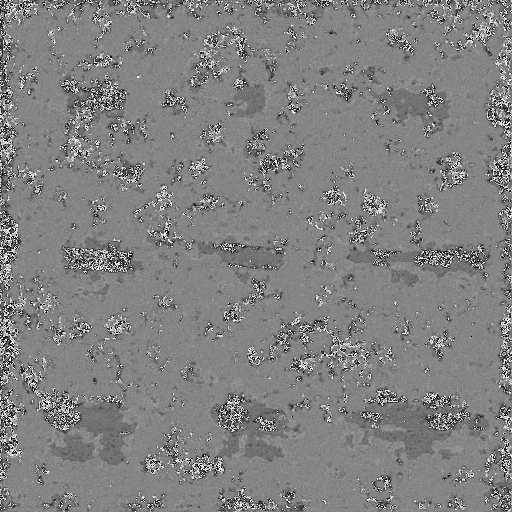

In [27]:
# Displays feature map before the last layer
model_edit = copy.deepcopy(model)
model_edit.decoder1.register_forward_hook(display_feature_map)

with torch.no_grad():
    output_tensor_edit = model_edit(input_batch)

In [91]:
with torch.no_grad():
    output_tensor_edit = model_edit(input_batch)

print('output_tensor_edit size: ', output_tensor_edit.size())

output_tensor_edit size:  torch.Size([1, 32, 1024, 1024])


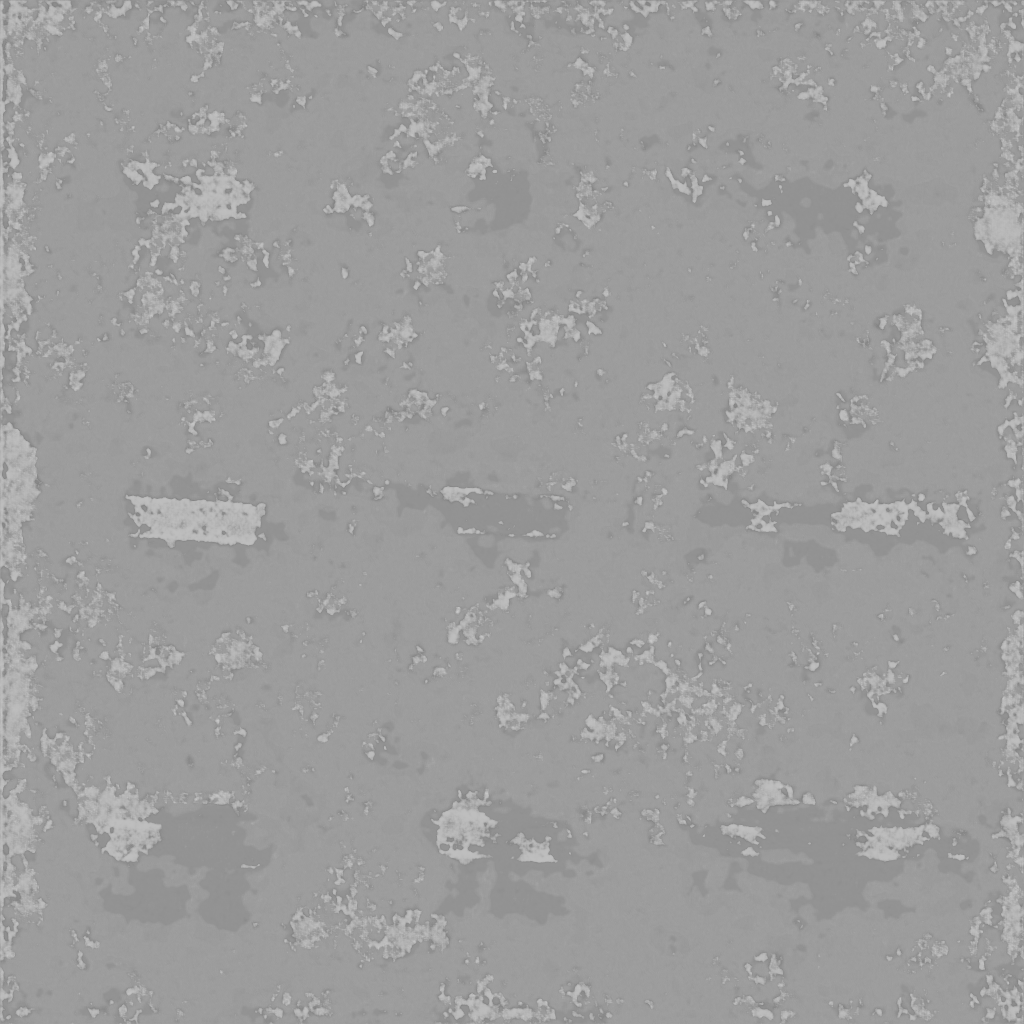

In [92]:
output_tensor_edit = output_tensor_edit.mean(dim=1)
output_image = transforms.ToPILImage()(output_tensor_edit[0, :])
output_image

display_activation_image
Inside Sequential forward

input:  <class 'tuple'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 256, 64, 64])
output size: torch.Size([1, 512, 64, 64])


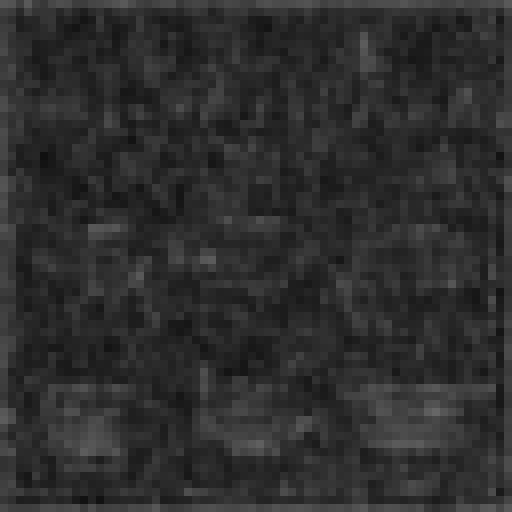

In [28]:
# Displays the innermost feature map, after the bottleneck
model_edit = copy.deepcopy(model)
model_edit.bottleneck.register_forward_hook(display_feature_map)

with torch.no_grad():
    output_tensor_edit = model_edit(input_batch)